In [1]:
# @title Import Libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_validate, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost

In [2]:
# @title Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# @title Load in 72 hour forecasts & ERA5 truth
# drive_data_path = "/content/drive/Shareddrives/Ishango/Programs/AIMS_MSc_Theses_Supervision/AIWP/Project26_MLStacking/data/oliver/"

# df = pd.read_pickle(drive_data_path + "era5_ml_setup_500geopotential_32x64_2020.pkl")

data_path = "/content/drive/MyDrive/_shared_drive_shortcut/MastersProject/Data/"
df =pd.read_pickle(data_path+"era5_ml_setup_500geopotential_32x64_2020.pkl")

#lead_times=[48, 72, 96, 120, 144, 168, 192, 216, 240]
lead_times=[72]


for lead_time in lead_times:
    print(lead_time)
    df_aiwp = pd.read_pickle(data_path + f"aiwp_ml_setup_500geopotential_32x64_2020_leadtime{lead_time}.pkl").drop(columns=["area_weight"])
    df_aiwp = df_aiwp.rename(columns={col: col + "_lt" + str(lead_time) for col in df_aiwp.columns if col not in ["time", "longitude", "latitude"]})
    df = df.merge(df_aiwp, on=["time", "longitude", "latitude"], how="outer")

print(f"Shape of df :{df.shape}")
df.head(20)

72
Shape of df :(1556480, 10)


,time,longitude,latitude,era5,area_weight,graphcast_lt72,pangu_lt72,neuralgcm_lt72,keisler_lt72,ifshres_lt72
0,2020-01-01,0.0,-87.1875,49846.941406,0.049068,NaN,NaN,NaN,NaN,NaN
1,2020-01-01,0.0,-81.5625,50196.523438,0.146730,NaN,NaN,NaN,NaN,NaN
2,2020-01-01,0.0,-75.9375,50391.101562,0.242980,NaN,NaN,NaN,NaN,NaN
3,2020-01-01,0.0,-70.3125,49667.398438,0.336890,NaN,NaN,NaN,NaN,NaN
4,2020-01-01,0.0,-64.6875,49277.945312,0.427555,NaN,NaN,NaN,NaN,NaN
5,2020-01-01,0.0,-59.0625,49780.332031,0.514103,NaN,NaN,NaN,NaN,NaN
6,2020-01-01,0.0,-53.4375,51072.132812,0.595699,NaN,NaN,NaN,NaN,NaN
7,2020-01-01,0.0,-47.8125,53136.964844,0.671559,NaN,NaN,NaN,NaN,NaN
8,2020-01-01,0.0,-42.1875,55094.839844,0.740951,NaN,NaN,NaN,NaN,NaN
9,2020-01-01,0.0,-36.5625,56504.953125,0.803208,NaN,NaN,NaN,NaN,NaN


In [4]:
# @title Filter for subset of data: Timeframe (2020-01-04 to 2021-01-04)

df_filtered = df[(df['time'] > '2020-01-04') & (df['time'] < '2021-01-04')]

print(f"df_filtered: {df_filtered.shape}")
df_filtered.head(20)

df_filtered: (1497088, 10)


,time,longitude,latitude,era5,area_weight,graphcast_lt72,pangu_lt72,neuralgcm_lt72,keisler_lt72,ifshres_lt72
14336,2020-01-04 12:00:00,0.0,-87.1875,50107.359375,0.049068,50021.562500,49925.054688,50081.550781,50177.917969,50105.789062
14337,2020-01-04 12:00:00,0.0,-81.5625,50161.546875,0.146730,50143.582031,50095.757812,50177.425781,50293.386719,50220.472656
14338,2020-01-04 12:00:00,0.0,-75.9375,50108.054688,0.242980,50099.382812,50014.726562,50109.554688,50315.734375,50148.429688
14339,2020-01-04 12:00:00,0.0,-70.3125,49919.265625,0.336890,49886.250000,49772.355469,49815.640625,49953.914062,49886.316406
14340,2020-01-04 12:00:00,0.0,-64.6875,49165.363281,0.427555,49110.785156,49001.562500,49110.273438,49023.488281,49137.992188
14341,2020-01-04 12:00:00,0.0,-59.0625,49217.367188,0.514103,49181.851562,49100.867188,49102.140625,48997.773438,49157.976562
14342,2020-01-04 12:00:00,0.0,-53.4375,50441.652344,0.595699,50457.812500,50391.183594,50314.250000,50042.070312,50378.234375
14343,2020-01-04 12:00:00,0.0,-47.8125,51854.097656,0.671559,51980.250000,52002.988281,51803.929688,51744.679688,51942.820312
14344,2020-01-04 12:00:00,0.0,-42.1875,53800.171875,0.740951,53993.757812,54217.996094,54034.671875,54349.183594,53914.562500
14345,2020-01-04 12:00:00,0.0,-36.5625,55942.164062,0.803208,56010.015625,56166.601562,56081.476562,56323.656250,55965.804688


In [5]:
df_filtered.isna().sum()

,0
time,0
longitude,0
latitude,0
era5,0
area_weight,0
graphcast_lt72,0
pangu_lt72,0
neuralgcm_lt72,0
keisler_lt72,32768
ifshres_lt72,0


In [ ]:
X = df_filtered[["graphcast_lt72", "pangu_lt72", "neuralgcm_lt72", "keisler_lt72","ifshres_lt72", "longitude", "latitude"]]
y = df_filtered["era5"]
area_weight = df_filtered["area_weight"]

In [ ]:
print(f"Shape of x :{X.shape}")
print(f"Shape of y : {y.shape}")

Shape of x :(1497088, 7)
Shape of y : (1497088,)


### Calculate Cross-Validation error using 10 folds
(note that no hyperparameter tuning is done - we choose to stick with the xgboost defaults since they are known to work well out-of-the-box)

Note that the current version of SciPy, expects NumPy to be between versions 1.21.6 and 1.28.0.

In [ ]:
cv_timeseries = TimeSeriesSplit(n_splits=10, max_train_size=32 * 64 * 2 * 60, test_size= 32 * 64 * 2 * 30, gap=32 * 64 * 2 * 5)



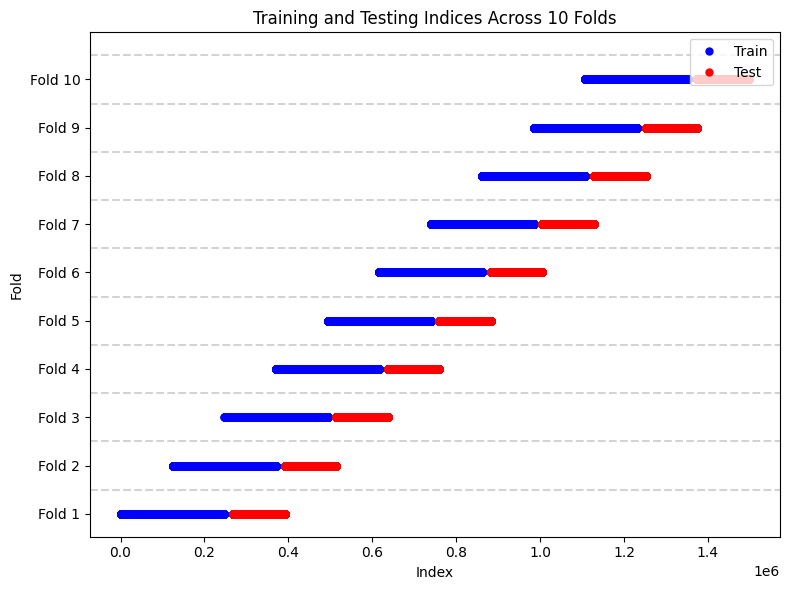

In [ ]:
# @title # Plot the train-test splits for each Fold
train_indices_list = []
test_indices_list = []
for train_index, test_index in cv_timeseries.split(X):
    train_indices_list.append(train_index)
    test_indices_list.append(test_index)

# Create a single plot
fig, ax = plt.subplots(figsize=(8, 6))

# Iterate through each fold
for i in range(10):
    # Plot training data.  Offset the y-values for each fold.
    ax.plot(train_indices_list[i], [i + 1] * len(train_indices_list[i]), 'bo', label='Train' if i == 0 else "", markersize=5)
    # Plot testing data.  Offset the y-values.
    ax.plot(test_indices_list[i], [i + 1] * len(test_indices_list[i]), 'ro', label='Test' if i == 0 else "", markersize=5)

    # Add a light gray line to visually separate folds (optional but helpful)
    ax.axhline(y=i + 1.5, color='lightgray', linestyle='--')

# Set labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Fold')
ax.set_yticks(range(1, 11))  # Set y-ticks to represent fold numbers
ax.set_yticklabels([f'Fold {i+1}' for i in range(10)])  #  Clearer y-tick labels
ax.set_title('Training and Testing Indices Across 10 Folds') #Added a title

# Add legend (only show labels once)
ax.legend(loc='upper right')

# Improve layout and display
plt.tight_layout()
plt.savefig(f'/content/drive/MyDrive/_shared_drive_shortcut/MastersProject/Plots/Training and Testing Indices Across Folds.pdf', dpi=300, bbox_inches="tight")

plt.show()


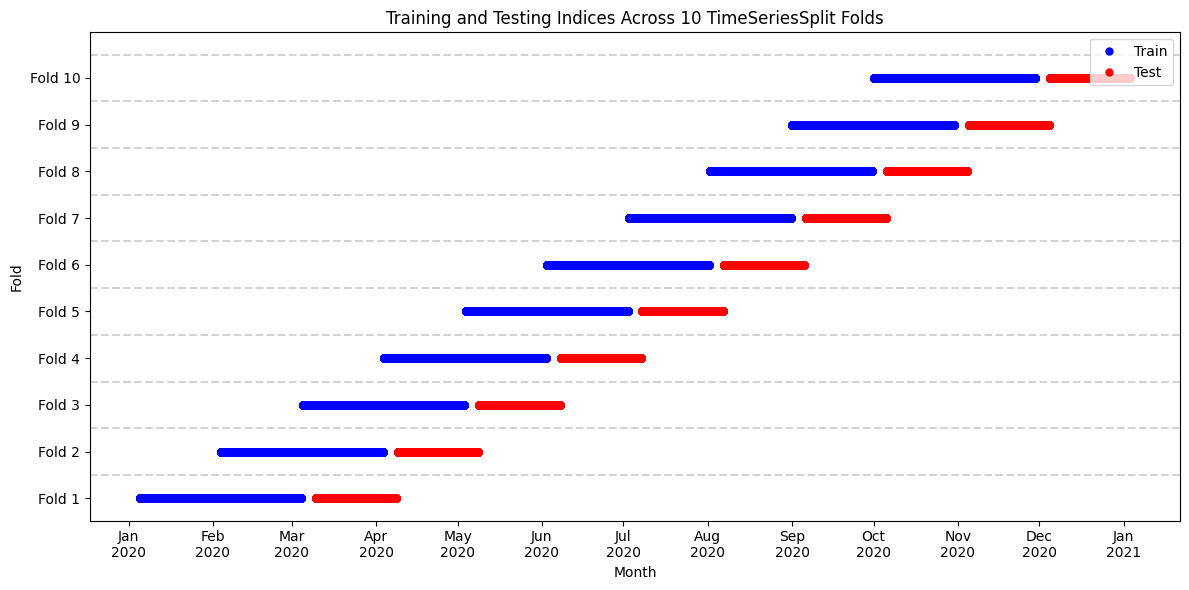

In [ ]:
import matplotlib.dates as mdates

# Extract datetime info using the filtered df
time_index = df_filtered["time"].reset_index(drop=True)

# Store train/test index lists
train_indices_list = []
test_indices_list = []
for train_index, test_index in cv_timeseries.split(X):
    train_indices_list.append(train_index)
    test_indices_list.append(test_index)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))  # Wider for clarity

# Plot each fold
for i in range(10):
    # Convert indices to datetime for x-axis
    train_times = time_index.iloc[train_indices_list[i]]
    test_times = time_index.iloc[test_indices_list[i]]

    ax.plot(train_times, [i + 1] * len(train_times), 'bo', label='Train' if i == 0 else "", markersize=5)
    ax.plot(test_times, [i + 1] * len(test_times), 'ro', label='Test' if i == 0 else "", markersize=5)
    ax.axhline(y=i + 1.5, color='lightgray', linestyle='--')

# Format x-axis as months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

# Labels and title
ax.set_xlabel('Month')
ax.set_ylabel('Fold')
ax.set_yticks(range(1, 11))
ax.set_yticklabels([f'Fold {i+1}' for i in range(10)])
ax.set_title('Training and Testing Indices Across 10 TimeSeriesSplit Folds')
ax.legend(loc='upper right')

# Improve layout and save
plt.tight_layout()
plt.savefig(f'/content/drive/MyDrive/_shared_drive_shortcut/MastersProject/Plots/Training_Testing_Folds_By_Month.pdf',
            dpi=300, bbox_inches="tight")

plt.show()


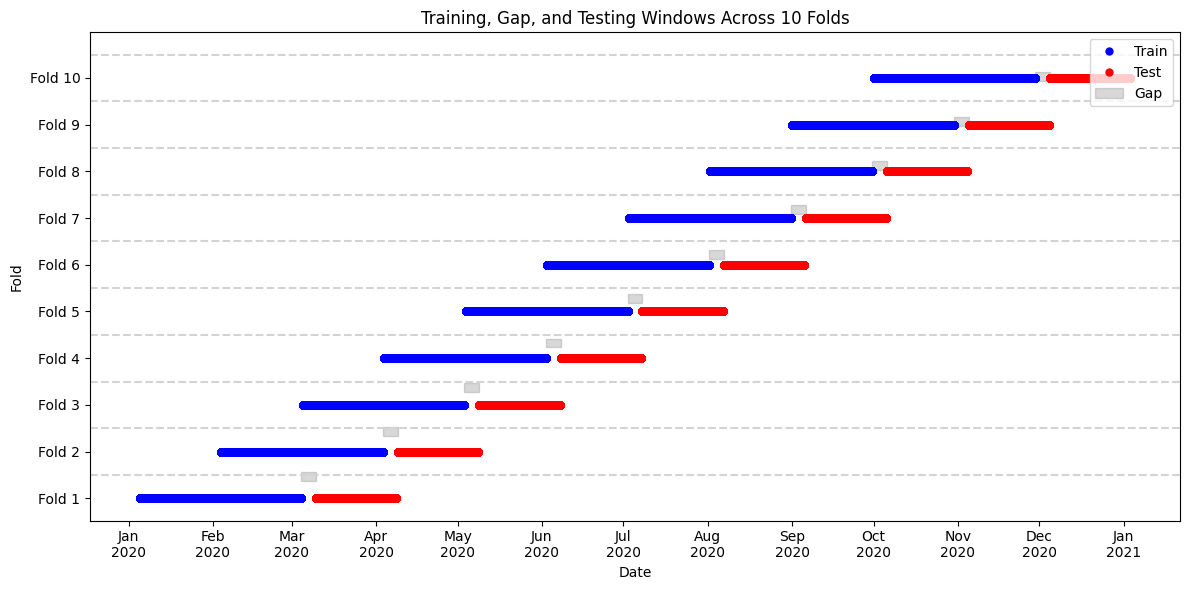

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Ensure 'time' column is datetime
time_index = df_filtered["time"].reset_index(drop=True)

# Store train/test index lists
train_indices_list = []
test_indices_list = []
for train_index, test_index in cv_timeseries.split(X):
    train_indices_list.append(train_index)
    test_indices_list.append(test_index)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

for i in range(10):
    train_idx = train_indices_list[i]
    test_idx = test_indices_list[i]

    train_times = time_index.iloc[train_idx]
    test_times = time_index.iloc[test_idx]

    # Plot training and testing data
    ax.plot(train_times, [i + 1] * len(train_times), 'bo', label='Train' if i == 0 else "", markersize=5)
    ax.plot(test_times, [i + 1] * len(test_times), 'ro', label='Test' if i == 0 else "", markersize=5)

    # Plot gap as shaded region between train and test
    last_train_time = train_times.iloc[-1]
    first_test_time = test_times.iloc[0]
    ax.axvspan(last_train_time, first_test_time, ymin=(i+0.9)/11, ymax=(i+1.1)/11,
               color='gray', alpha=0.3, label='Gap' if i == 0 else "")

    # Horizontal separator between folds
    ax.axhline(y=i + 1.5, color='lightgray', linestyle='--')

# Format x-axis as months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

# Labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Fold')
ax.set_yticks(range(1, 11))
ax.set_yticklabels([f'Fold {i+1}' for i in range(10)])
ax.set_title('Training, Gap, and Testing Windows Across 10 Folds')
ax.legend(loc='upper right')

# Layout and save
plt.tight_layout()
plt.savefig(f'/content/drive/MyDrive/_shared_drive_shortcut/MastersProject/Plots/Training_Gap_Testing_Folds_By_Month.pdf',
            dpi=300, bbox_inches="tight")

plt.show()


In [ ]:
fold_ranges = []

for i, (train_idx, test_idx) in enumerate(zip(train_indices_list, test_indices_list)):
    train_times = time_index.iloc[train_idx]
    test_times = time_index.iloc[test_idx]

    fold_info = {
        "Fold": f"Fold {i+1}",
        "Train Start": train_times.min().strftime('%Y-%m-%d'),
        "Train End": train_times.max().strftime('%Y-%m-%d'),
        "Gap Start": (train_times.max() + pd.Timedelta(hours=12)).strftime('%Y-%m-%d'),
        "Gap End": (test_times.min() - pd.Timedelta(hours=12)).strftime('%Y-%m-%d'),
        "Test Start": test_times.min().strftime('%Y-%m-%d'),
        "Test End": test_times.max().strftime('%Y-%m-%d'),
    }
    fold_ranges.append(fold_info)

fold_ranges_df = pd.DataFrame(fold_ranges)
print(fold_ranges_df)


      Fold Train Start   Train End   Gap Start     Gap End  Test Start  \
0   Fold 1  2020-01-05  2020-03-04  2020-03-05  2020-03-09  2020-03-10   
1   Fold 2  2020-02-04  2020-04-03  2020-04-04  2020-04-08  2020-04-09   
2   Fold 3  2020-03-05  2020-05-03  2020-05-04  2020-05-08  2020-05-09   
3   Fold 4  2020-04-04  2020-06-02  2020-06-03  2020-06-07  2020-06-08   
4   Fold 5  2020-05-04  2020-07-02  2020-07-03  2020-07-07  2020-07-08   
5   Fold 6  2020-06-03  2020-08-01  2020-08-02  2020-08-06  2020-08-07   
6   Fold 7  2020-07-03  2020-08-31  2020-09-01  2020-09-05  2020-09-06   
7   Fold 8  2020-08-02  2020-09-30  2020-10-01  2020-10-05  2020-10-06   
8   Fold 9  2020-09-01  2020-10-30  2020-10-31  2020-11-04  2020-11-05   
9  Fold 10  2020-10-01  2020-11-29  2020-11-30  2020-12-04  2020-12-05   

     Test End  
0  2020-04-08  
1  2020-05-08  
2  2020-06-07  
3  2020-07-07  
4  2020-08-06  
5  2020-09-05  
6  2020-10-05  
7  2020-11-04  
8  2020-12-04  
9  2021-01-03  


In [ ]:
xgb = xgboost.XGBRegressor(random_state=42, device="cuda")

nested_score = cross_validate(xgb, X=X, y=y, cv=cv_timeseries,
                              scoring=('neg_mean_squared_error', 'r2'),
                              params={'sample_weight': area_weight}
                              )

nested_score

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:40:00] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


{'fit_time': array([1.03773308, 0.47946358, 0.48164439, 0.4802649 , 0.47718   ,
        0.45970535, 0.45973539, 0.49096394, 0.47279429, 0.46575236]),
 'score_time': array([0.0673008 , 0.02508259, 0.02378702, 0.0247035 , 0.02209139,
        0.02598286, 0.02202106, 0.02568936, 0.02252269, 0.02318335]),
 'test_neg_mean_squared_error': array([-27645.70898438, -23012.20507812, -16887.38476562, -21405.33203125,
        -18679.71289062, -17566.68945312, -17280.70703125, -15445.49023438,
        -12897.01855469, -11311.56347656]),
 'test_r2': array([0.99787754, 0.99794739, 0.99848467, 0.99799347, 0.9983964 ,
        0.9983449 , 0.9985525 , 0.99880034, 0.99891514, 0.9989267 ])}

In [ ]:
# @title # RMSE Comparison for each model and fold
results = {}

for fold, (train_index, test_index) in enumerate(cv_timeseries.split(X)):
    print(f"Fold {fold+1}:")
    fold_results = {}

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb = xgboost.XGBRegressor(random_state=42, device="cuda")
    xgb.fit(X_train, y_train, sample_weight=area_weight.iloc[train_index])

    y_pred = xgb.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"  mse: {mse}")

    area_weighted_rmse = np.sqrt(((y_test-y_pred)**2 * area_weight.iloc[test_index]).mean() / area_weight.iloc[test_index].mean())
    print(f"  PiggyCast: area weighted rmse: {area_weighted_rmse}")
    fold_results["PiggyCast"] = area_weighted_rmse

    for model in ["graphcast_lt72", "pangu_lt72", "neuralgcm_lt72", "keisler_lt72","ifshres_lt72"]:
        area_weighted_rmse = np.sqrt(((y_test-X_test[model])**2 * area_weight.iloc[test_index]).mean() / area_weight.iloc[test_index].mean())
        print(f"  {model} area weighted rmse: {area_weighted_rmse}")
        fold_results[model] = area_weighted_rmse

    results[fold+1] = fold_results



Fold 1:
  mse: 27645.708984375
  PiggyCast: area weighted rmse: 120.52433515835023
  graphcast_lt72 area weighted rmse: 122.85387708812033
  pangu_lt72 area weighted rmse: 135.08533958019098
  neuralgcm_lt72 area weighted rmse: 108.71967205337731
  keisler_lt72 area weighted rmse: 171.15335280788656
  ifshres_lt72 area weighted rmse: 131.52903243672063
Fold 2:
  mse: 23012.205078125
  PiggyCast: area weighted rmse: 113.576995939114
  graphcast_lt72 area weighted rmse: 121.55502280923785
  pangu_lt72 area weighted rmse: 134.301915560045
  neuralgcm_lt72 area weighted rmse: 110.53258883735597
  keisler_lt72 area weighted rmse: 171.75634762371809
  ifshres_lt72 area weighted rmse: 130.6921929942073
Fold 3:
  mse: 16887.384765625
  PiggyCast: area weighted rmse: 102.33662164945432
  graphcast_lt72 area weighted rmse: 115.12777744553853
  pangu_lt72 area weighted rmse: 124.96075061143948
  neuralgcm_lt72 area weighted rmse: 106.80123183454789
  keisler_lt72 area weighted rmse: 160.474631840

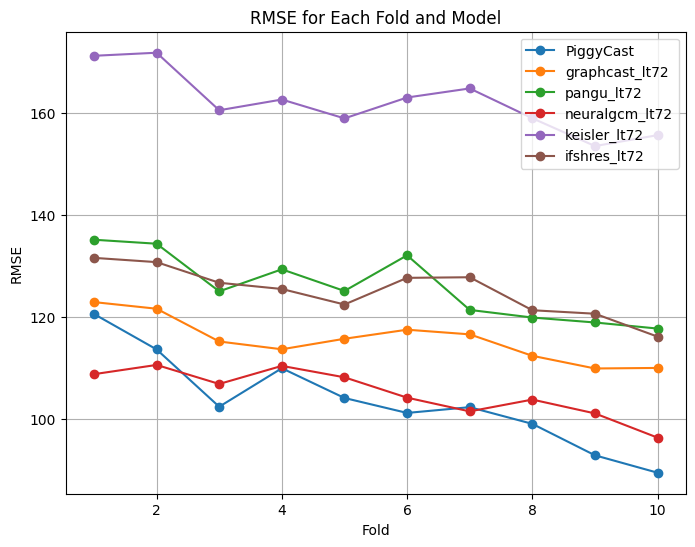

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

for model in results[1].keys():  # Iterate through all model names
    rmse_values = [results[fold][model] for fold in results]
    fold_numbers = list(results.keys())
    ax.plot(fold_numbers, rmse_values, label=model, marker='o')

ax.set_xlabel('Fold')
ax.set_ylabel('RMSE')
ax.set_title('RMSE for Each Fold and Model')
ax.legend(loc="upper right")
plt.grid(True)
plt.savefig(f'/content/drive/MyDrive/_shared_drive_shortcut/MastersProject/Plots/RMSE for Each Fold and Model.pdf', dpi=300, bbox_inches="tight")

plt.show()


In [ ]:
# @title SHAP values
import shap
explainer = shap.TreeExplainer(model=xgb)

shap_values = explainer(X_train)


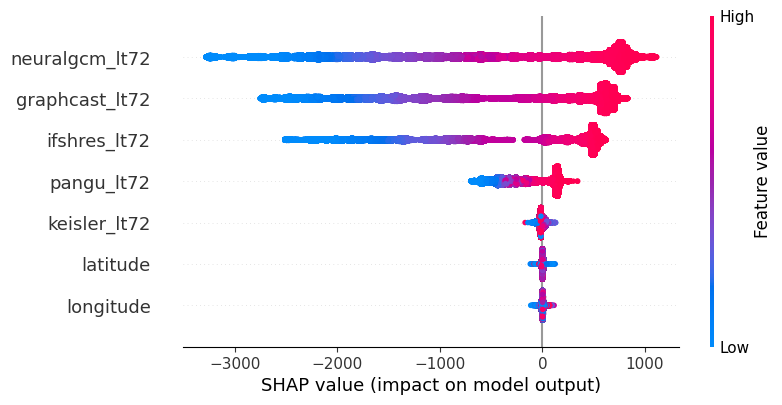

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
shap.plots.beeswarm(shap_values)
plt.savefig('/content/drive/MyDrive/_shared_drive_shortcut/MastersProject/Plots/shap_beeswarm_plot.png', dpi=300, bbox_inches="tight")




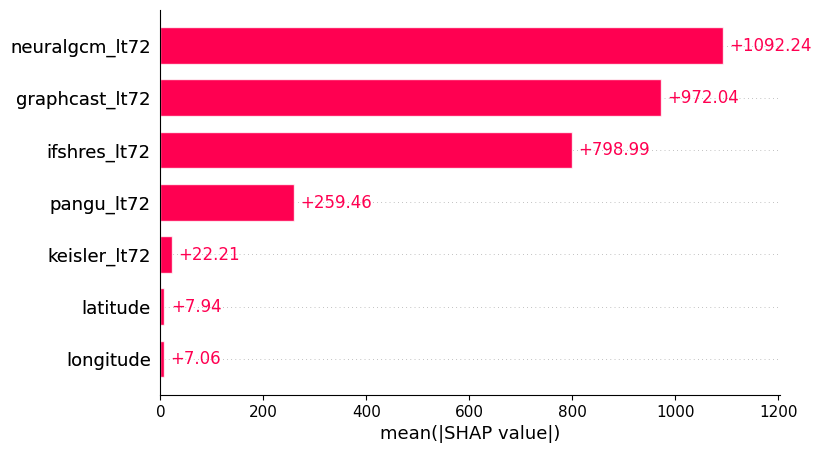

<Figure size 640x480 with 0 Axes>

In [ ]:
shap.plots.bar(shap_values, max_display=12)
plt.savefig('/content/drive/MyDrive/_shared_drive_shortcut/MastersProject/Plots/shap_bar_plot.png', dpi=300, bbox_inches="tight")

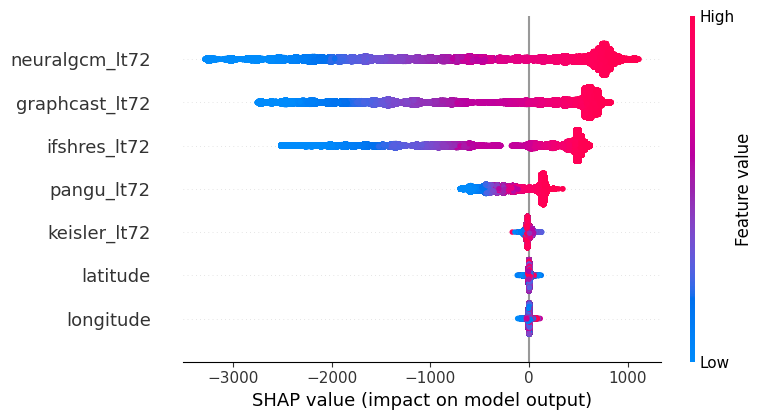

In [ ]:
shap.summary_plot(shap_values, X_train)